In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import json
import torch
from torch import nn
from torch.nn import functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
import significantdigits as sig
import matplotlib.image as mpimg
import glob
from IPython.display import display
from IPython.display import Image as Im
from PIL import Image
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
import random
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_rel
from typing import Tuple
import matplotlib
import re
from concurrent.futures import ThreadPoolExecutor
import threading
from scipy import stats
from nilearn import masking, image
import scipy.ndimage as ndimage


### Identify Stragglers

In [1]:
for i in range(128):
    f = open(f"/scratch/vinuyans/skips/slurm/t1_{i}.out", 'r')
    count = False

    for line in f: 
            line = line.strip()
            if 'Third Axis Testing Done' in line: count=True

    if not count: 
          print(f"/scratch/vinuyans/skips/slurm/t1_{i}.out")

In [2]:
for j in range(1,6):
    for i in range(256):
        f = open(f"/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_{j}_{i}.log", 'r')
        # f = open(f"/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_{j}_{i}.log", 'r')
        count=False
        for line in f: 
            line = line.strip()
            if 'Classifier' in line: count=True

        if not count: 
            print(f"/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_{j}_{i}.log")
            # print(f"/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_{j}_{i}.log")


/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_5_221.log


In [6]:
s = """/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_1_22.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_1_44.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_1_53.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_1_200.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_1_204.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_2_111.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_2_122.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_2_221.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_3_23.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_3_102.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_3_121.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_3_173.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_3_248.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_132.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_160.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_175.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_186.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_206.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_241.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_4_242.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_5_100.log
/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/10subs/axial_5_172.log"""

tmp=[]
for i in s.split('\n'):
    if i == ' ' or i=='': continue
    # print('int', i.strip().split('_')[-1].split('.log')[0] )
    tmp.append(int(i.strip().split('_')[-1].split('.log')[0]))

print(sorted(list(set(tmp))))

[22, 23, 44, 53, 100, 102, 111, 121, 122, 132, 160, 172, 173, 175, 186, 200, 204, 206, 221, 241, 242, 248]


## Skip Count (5 subjects)

In [2]:
def count_skipped_ops(filename):

    # f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/axial_1_{i}.log'
    # tmp = int(filename.split('.log')[0].split('_')[-1])
    # # # if tmp in [101, 102, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 196]: return None
    # if tmp in [3, 77, 80, 82, 119, 120, 122, 161, 27, 123, 165, 166, 203, 33, 78, 167]: return None
    # if tmp in [36, 171, 241, 136, 167, 235, 248, 106, 221, 16, 54, 61, 134, 168, 17, 49, 85, 103, 150, 221]: return None

    # print(filename)
    f = open(filename, 'r')

    skip_count = {}
    start_printing = False
    conv_counter = 0

    for line in f: 
        line = line.strip()
        if 'Input' in line:
            start_printing = True
        if start_printing:
            if 'Input' in line or 'Encode' in line or 'Bottle' in line or 'Decode' in line or 'Output block' in line or 'Classifier' in line: 
                block = line.split(': ')[-1]
                skip_count[block] = {}
                conv_counter = 0

            if 'SKIP' in line:
                tmp = line.split('count ')[-1].strip('()').split(', ')
                skip_count[block][conv_counter] = {'Count': int(tmp[0]), 'Total': int(tmp[1]), 'Ratio': float(int(tmp[0])/int(tmp[1])) }
                conv_counter += 1

    block_counter = {}
    for block in ['Input', 'Encode1', 'Encode2', 'Encode3', 'Encode4', 'Bottleneck', 'Decode4', 'Decode3', 'Decode2', 'Decode1', 'Output block', 'Classifier']:
        block_counter[block] = {"Labels": [], "Ratio": []}
        for num, r in skip_count[block].items():
            # print(r)
            block_counter[block]["Labels"].append(f"Conv {num}")
            block_counter[block]["Ratio"].append(float(r['Ratio']))

    return block_counter


def aggregate_mean_ratios(dictionaries):
    # Initialize a dictionary to store aggregated ratio values for each convolutional layer
    aggregated_ratios = {}
    
    # Iterate through each dictionary
    for dictionary in dictionaries:
        # print(dictionary)
        if dictionary is None: continue
        for layer in dictionary:
            # Extract labels and ratio values
            labels = dictionary[layer].get('Labels', [])
            ratios = dictionary[layer].get('Ratio', [])

            if layer not in aggregated_ratios.keys(): 
                aggregated_ratios[layer] = {}
            
            # Iterate through labels and corresponding ratio values
            for label, ratio in zip(labels, ratios):
                # If label already exists in aggregated_ratios, add ratio value to list
                if label in aggregated_ratios[layer]:
                    aggregated_ratios[layer][label].append(ratio)
                # If label is new, initialize list with ratio value
                else:
                    aggregated_ratios[layer][label] = [ratio]
    
    # Calculate mean ratio for each convolutional layer
    mean_ratios = {}
    for layer in aggregated_ratios:
        mean_ratios[layer] = {}
        for label, ratios in aggregated_ratios[layer].items():
            mean_ratios[layer][label] = [sum(ratios) / len(ratios)]
    
    return aggregated_ratios, mean_ratios

def ratio_distribution(thresh1, thresh08, thresh05, thresh02):
    for block in ['Input', 'Encode1', 'Encode2', 'Encode3', 'Encode4', 'Bottleneck', 'Decode4', 'Decode3', 'Decode2', 'Decode1', 'Output block', 'Classifier']:
        fig, axes = plt.subplots(1, 1, figsize=(20,4))

        for conv in thresh1[block]:
            axes[0].scatter(np.arange(len(thresh1[block][conv])), thresh1[block][conv], alpha=0.5, label=conv)
            # axes[1].scatter(np.arange(len(thresh08[block][conv])), thresh08[block][conv], alpha=0.5, label=conv)
            # axes[2].scatter(np.arange(len(thresh05[block][conv])), thresh05[block][conv], alpha=0.5, label=conv)
            # axes[3].scatter(np.arange(len(thresh02[block][conv])), thresh02[block][conv], alpha=0.5, label=conv)
            
        axes[0].legend() #, axes[1].legend(), axes[2].legend(), axes[3].legend()
        axes[0].set_ylabel('NaN Ratio') #, axes[1].set_ylabel('NaN Ratio')
        axes[0].set_title('Threshold 1') #; axes[1].set_title('Threshold 0.8'), axes[2].set_title('Threshold 0.5'); axes[3].set_title('Threshold 0.2')
        plt.suptitle(f"{block} Mean NaN Ratio Distribution Across Sagittal View")
        # break


def average_block_ratio(aggregated_ratios, title, axes):
    # avg_thresh = {'0': [], '0.2': [], '0.5': [], '0.8': [], '1': []}
    # avg_thresh = {'0.2': [], '0.5': [], '0.8': [], '1': []}
    # avg_thresh = {'0.5': [], '1': []}    

    for thresh in aggregated_ratios:
        avg_thresh = {thresh: {}}
        std_thresh = {thresh: {}}
        subs_thresh = {thresh: {}}

        for block in ['Input', 'Encode1', 'Encode2', 'Encode3', 'Encode4', 'Bottleneck', 'Decode4', 'Decode3', 'Decode2', 'Decode1', 'Output block', 'Classifier']:

            avg_thresh[thresh][block] = []
            std_thresh[thresh][block] = []

            for num, sub in enumerate(aggregated_ratios[thresh]):
                # sub_id = list(sub.keys())[0]

                if not num in list(subs_thresh[thresh].keys()):
                    subs_thresh[thresh][num] = {}
                
                subs_thresh[thresh][num][block] = []

                for conv in sub[block]:
                    avg_thresh[thresh][block].append( sub[block][conv] )
                    # std_thresh[thresh][block].append( sub[sub_id][block][conv] )

                    subs_thresh[thresh][num][block].append( sub[block][conv] )

                subs_thresh[thresh][num][block] = np.mean( subs_thresh[thresh][num][block] )

            #average across convolutions for a block as well as across subjects
            std_thresh[thresh][block] = np.std( avg_thresh[thresh][block] )
            avg_thresh[thresh][block] = np.mean( avg_thresh[thresh][block] )
            # print( avg_thresh[thresh][block] )



        # print(std_thresh)
        # for sub in subs_thresh[thresh]:
        #     axes.plot(list(subs_thresh[thresh][sub].values()), marker='x', alpha=0.3, color='blue', label =f'sub-{sub}')
        
        axes.plot(list(avg_thresh[thresh].values()), marker='o', label=f'Threshold {thresh}')
        avg = np.array(list(avg_thresh[thresh].values()))
        stdev = np.array(list(std_thresh[thresh].values()))
        axes.fill_between(range(len(list(avg_thresh[thresh].values()))), avg - stdev, avg + stdev, alpha=0.3)
        axes.set_ylim(-0.1,1)
        axes.set_title(f'{title}', fontsize=18)
        axes.set_xticks(np.arange(len(avg_thresh[thresh].keys())), list(avg_thresh[thresh].keys()), rotation=30, fontsize=13)
        axes.legend();

def nanratio_per_slice(aggregated_ratios, trim, title, axes):


    avg_slice = {}
    std_slice = {}
    for thresh in aggregated_ratios:
        avg_slice[thresh] = {}
        std_slice[thresh] = {}

        # print(len(aggregated_ratios[thresh]))
        # print(aggregated_ratios[thresh][1])

        for num, sub in enumerate(aggregated_ratios[thresh]):
            # print(sub)
            # print(type(sub))
            avg_slice[thresh][num] = []
            std_slice[thresh][num] = []

            for slice in sub:

                nanratio = []
                # print(slice.keys())
                for block in slice:
                    # trim architecture to relevant blocks
                    if trim:
                        pattern = r"Encode2|Encode3|Encode4|Bottleneck|Decode4|Decode3"

                        if re.search(pattern, block):
                            # print(slice[block]['Ratio'])
                            nanratio.extend(slice[block]['Ratio'])
                    else:
                        nanratio.extend(slice[block]['Ratio'])


                # print(nanratio)
                avg_slice[thresh][num].append(np.mean(nanratio))
                std_slice[thresh][num].append(np.std(nanratio))

                # nanratio = np.array(nanratio).ravel()
                # print(nanratio)
                # break

        
        avg = np.mean( np.array(list(avg_slice[thresh].values())), axis=0)
        stdev = np.std( np.array(list(avg_slice[thresh].values())), axis=0)

        axes.plot(avg, label=f'Threshold {thresh}')
        axes.fill_between(range(len(avg)), avg - stdev, avg + stdev, alpha=0.3)
        axes.set_ylim(-0.1,1)
        axes.set_title(f'{title}', fontsize=18)
        axes.legend()
        # axes.set_xticks(np.arange(len(avg_slice[thresh])), list(avg_slice[thresh]), rotation=30);

def normalized_nanratio_per_slice(aggregated_ratios, trim, title, axes):


    avg_slice = {}
    std_slice = {}
    max_slices = max([len(sub) for thresh in aggregated_ratios for sub in aggregated_ratios[thresh] if sub is not None])

    for thresh in aggregated_ratios:
        avg_slice[thresh] = {}
        std_slice[thresh] = {}


        for num, sub in enumerate(aggregated_ratios[thresh]):
            # print(sub)
            # print(len(sub))
            avg_slice[thresh][num] = []
            std_slice[thresh][num] = []

            for slice in sub:

                nanratio = []
                for block in slice:
                    # trim architecture to relevant blocks
                    if trim:
                        pattern = r"Encode2|Encode3|Encode4|Bottleneck|Decode4|Decode3"

                        if re.search(pattern, block):
                            # print(slice[block]['Ratio'])
                            nanratio.extend(slice[block]['Ratio'])
                    else:
                        nanratio.extend(slice[block]['Ratio'])


                avg_slice[thresh][num].append(np.mean(nanratio))
                std_slice[thresh][num].append(np.std(nanratio))

                # nanratio = np.array(nanratio).ravel()
                # print(nanratio)
                # break
            
            if len(sub) < max_slices:
                for _ in range(max_slices - len(sub)):
                    avg_slice[thresh][num].append(np.nan)
                    std_slice[thresh][num].append(np.nan)

        normalized_indices = np.linspace(0, 1, max_slices)

        
        avg = np.nanmean( np.array(list(avg_slice[thresh].values())), axis=0)
        stdev = np.nanstd( np.array(list(avg_slice[thresh].values())), axis=0)

        axes.plot(normalized_indices, avg, label=f'Threshold {thresh}')
        axes.fill_between(normalized_indices, avg - stdev, avg + stdev, alpha=0.3)
        axes.set_ylim(-0.1,1)
        axes.set_xlabel('Normalized Brain Slices', fontsize=12)
        axes.set_title(f'{title}')

def total_percentage(allsubs_ratio):

    total_perc = {}
    trimmed_perc = {}
    pattern = r"Encode2|Encode3|Encode4|Bottleneck|Decode4|Decode3"

    for thresh in allsubs_ratio:

        total_perc[thresh] = []
        trimmed_perc[thresh] = []

        for slices in allsubs_ratio[thresh]:

            for sub in slices:
                for block in sub.items():

                    total_perc[thresh].extend(block[1]['Ratio'])

                    if re.search(pattern, block[0]):
                        trimmed_perc[thresh].extend(block[1]['Ratio'])

        print(f"Threshold {thresh} total skipped convolutions: {np.mean(total_perc[thresh])*100:.2f}")
        print(f"Threshold {thresh} total skipped convolutions for relevant layers: {np.mean(trimmed_perc[thresh])*100:.2f}")



#### Loading up FastSurfer slices in Jupyter Notebook

In [133]:
axial_0025531_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_1_{i}.log') for i in range(256)]  
axial_0003002_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_2_{i}.log') for i in range(256)]  
axial_0025011_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_3_{i}.log') for i in range(256)]  
axial_0025248_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_4_{i}.log') for i in range(256)]  
axial_0025350_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/axial_5_{i}.log') for i in range(256)]  

axial_0025531_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/axial_1_{i}.log') for i in range(256)]  
axial_0003002_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/axial_2_{i}.log') for i in range(256)]  
axial_0025011_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/axial_3_{i}.log') for i in range(256)]  
axial_0025248_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/axial_4_{i}.log') for i in range(256)]  
axial_0025350_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/axial_5_{i}.log') for i in range(256)]  


In [28]:
sagittal_0025531_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/sagittal_1_{i}.log') for i in range(256)]  
sagittal_0003002_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/sagittal_2_{i}.log') for i in range(256)]  
sagittal_0025011_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/sagittal_3_{i}.log') for i in range(256)]  
sagittal_0025248_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/sagittal_4_{i}.log') for i in range(256)]  
sagittal_0025350_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/sagittal_5_{i}.log') for i in range(256)]  

sagittal_0025531_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/sagittal_1_{i}.log') for i in range(256)]  
sagittal_0003002_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/sagittal_2_{i}.log') for i in range(256)]  
sagittal_0025011_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/sagittal_3_{i}.log') for i in range(256)]  
sagittal_0025248_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/sagittal_4_{i}.log') for i in range(256)]  
sagittal_0025350_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/sagittal_5_{i}.log') for i in range(256)]  


In [10]:
coronal_0025531_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/coronal_1_{i}.log') for i in range(256)]  
coronal_0003002_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/coronal_2_{i}.log') for i in range(256)]  
coronal_0025011_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/coronal_3_{i}.log') for i in range(256)]  
coronal_0025248_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/coronal_4_{i}.log') for i in range(256)]  
coronal_0025350_thresh1 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh1/coronal_5_{i}.log') for i in range(256)]  


coronal_0025531_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/coronal_1_{i}.log') for i in range(256)]  
coronal_0003002_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/coronal_2_{i}.log') for i in range(256)]  
coronal_0025011_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/coronal_3_{i}.log') for i in range(256)]  
coronal_0025248_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/coronal_4_{i}.log') for i in range(256)]  
coronal_0025350_thresh05 = [count_skipped_ops(f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/allsubs_skipconv/thresh05/coronal_5_{i}.log') for i in range(256)]  


#### Loading up FastSurfer slices from pickle file

In [3]:
sagittal_thresh1_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_sagittal_thresh1.pkl', 'rb'))
sagittal_thresh05_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_sagittal_thresh05.pkl', 'rb'))

axial_thresh1_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_axial_thresh1.pkl', 'rb'))
axial_thresh05_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_axial_thresh05.pkl', 'rb'))

coronal_thresh1_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_coronal_thresh1.pkl', 'rb'))
coronal_thresh05_5subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/5subs_skipconv_coronal_thresh05.pkl', 'rb'))

sagittal_thresh1_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_sagittal_thresh1.pkl', 'rb'))
sagittal_thresh05_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_sagittal_thresh05.pkl', 'rb'))

axial_thresh1_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_axial_thresh1.pkl', 'rb'))
axial_thresh05_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_axial_thresh05.pkl', 'rb'))

coronal_thresh1_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_coronal_thresh1.pkl', 'rb'))
coronal_thresh05_10subs = pickle.load(open('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/10subs_skipconv_coronal_thresh05.pkl', 'rb'))



#### Brain Slice Aggregation

In [43]:
# THRESHOLD 1
tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(coronal_thresh1_5subs) + list(coronal_thresh1_10subs) ] )
coronal_aggregated_ratios_thresh1 = tmp[:, 0] 
coronal_mean_ratios_thresh1 = tmp[:, 1]

tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(axial_thresh1_5subs) + list(axial_thresh1_10subs) ] )
axial_aggregated_ratios_thresh1 = tmp[:, 0] 
axial_mean_ratios_thresh1 = tmp[:, 1]

tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(sagittal_thresh1_5subs) + list(sagittal_thresh1_10subs) ] )
sagittal_aggregated_ratios_thresh1 = tmp[:, 0] 
sagittal_mean_ratios_thresh1 = tmp[:, 1]

# THRESHOLD 0.5
tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(coronal_thresh05_5subs) + list(coronal_thresh05_10subs) ] )
coronal_aggregated_ratios_thresh05 = tmp[:, 0] 
coronal_mean_ratios_thresh05 = tmp[:, 1]

tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(axial_thresh05_5subs) + list(axial_thresh05_10subs) ] )
axial_aggregated_ratios_thresh05 = tmp[:, 0] 
axial_mean_ratios_thresh05 = tmp[:, 1]

tmp = np.array( [ aggregate_mean_ratios(sub) for sub in  list(sagittal_thresh05_5subs) + list(sagittal_thresh05_10subs) ] )
sagittal_aggregated_ratios_thresh05 = tmp[:, 0] 
sagittal_mean_ratios_thresh05 = tmp[:, 1]


#### Get Total Percentage of Skipped Convolutions

In [ ]:
total_percentage({'1': list(sagittal_thresh1_5subs) + list(sagittal_thresh1_10subs) +
                        list(axial_thresh1_5subs) + list(axial_thresh1_10subs) + 
                        list(coronal_thresh1_5subs) + list(coronal_thresh1_10subs)  ,
                    '0.5': list(sagittal_thresh05_5subs) + list(sagittal_thresh05_10subs) +
                        list(axial_thresh05_5subs) + list(axial_thresh05_10subs) + 
                        list(coronal_thresh05_5subs) + list(coronal_thresh05_10subs)
                    })


Threshold 1 total skipped convolutions: 33.49
Threshold 1 total skipped convolutions for relevant layers: 50.86
Threshold 0.5 total skipped convolutions: 43.89
Threshold 0.5 total skipped convolutions for relevant layers: 68.81


#### Raw Skipped Convolutions

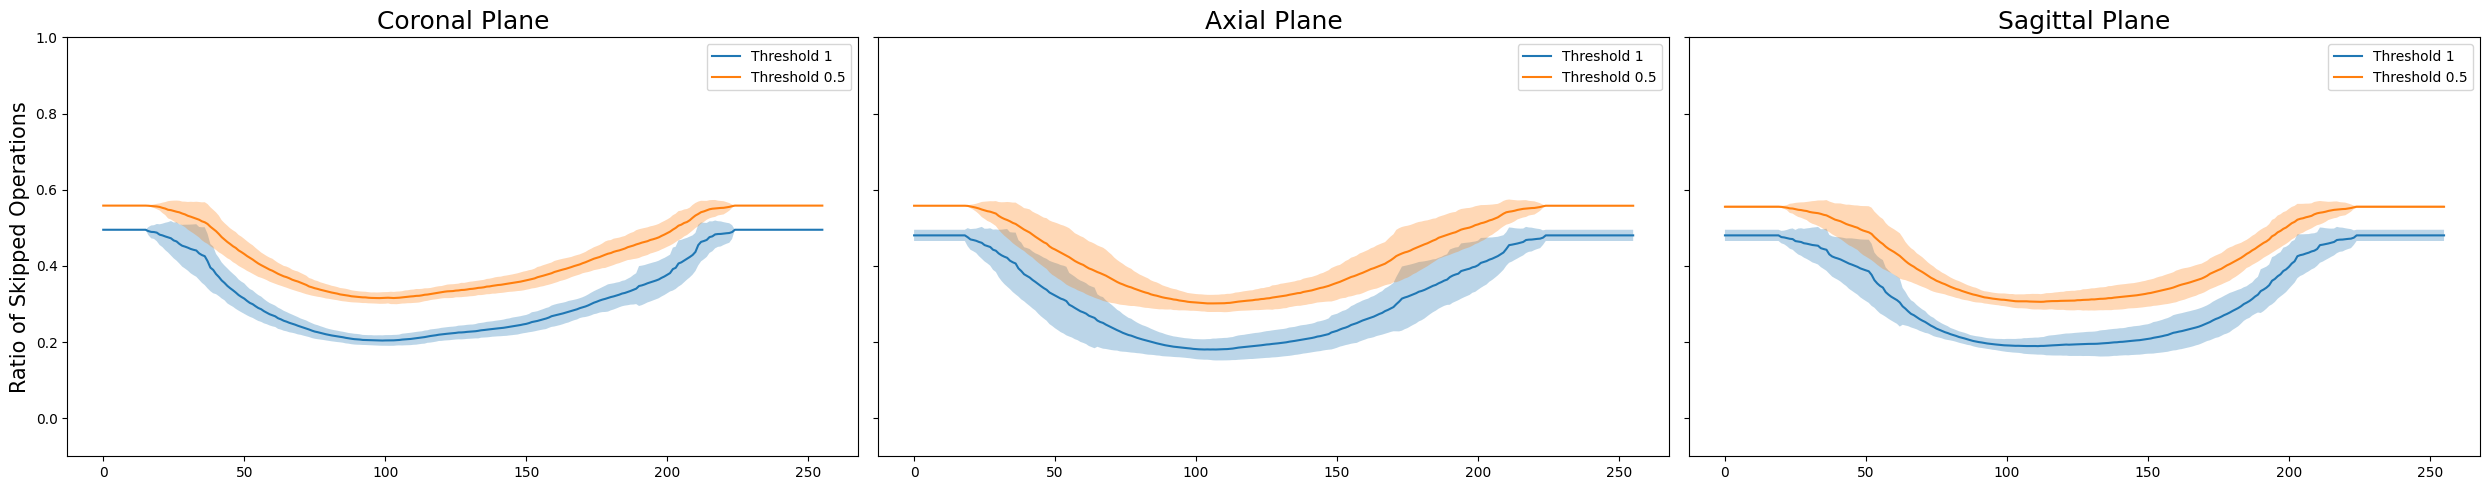

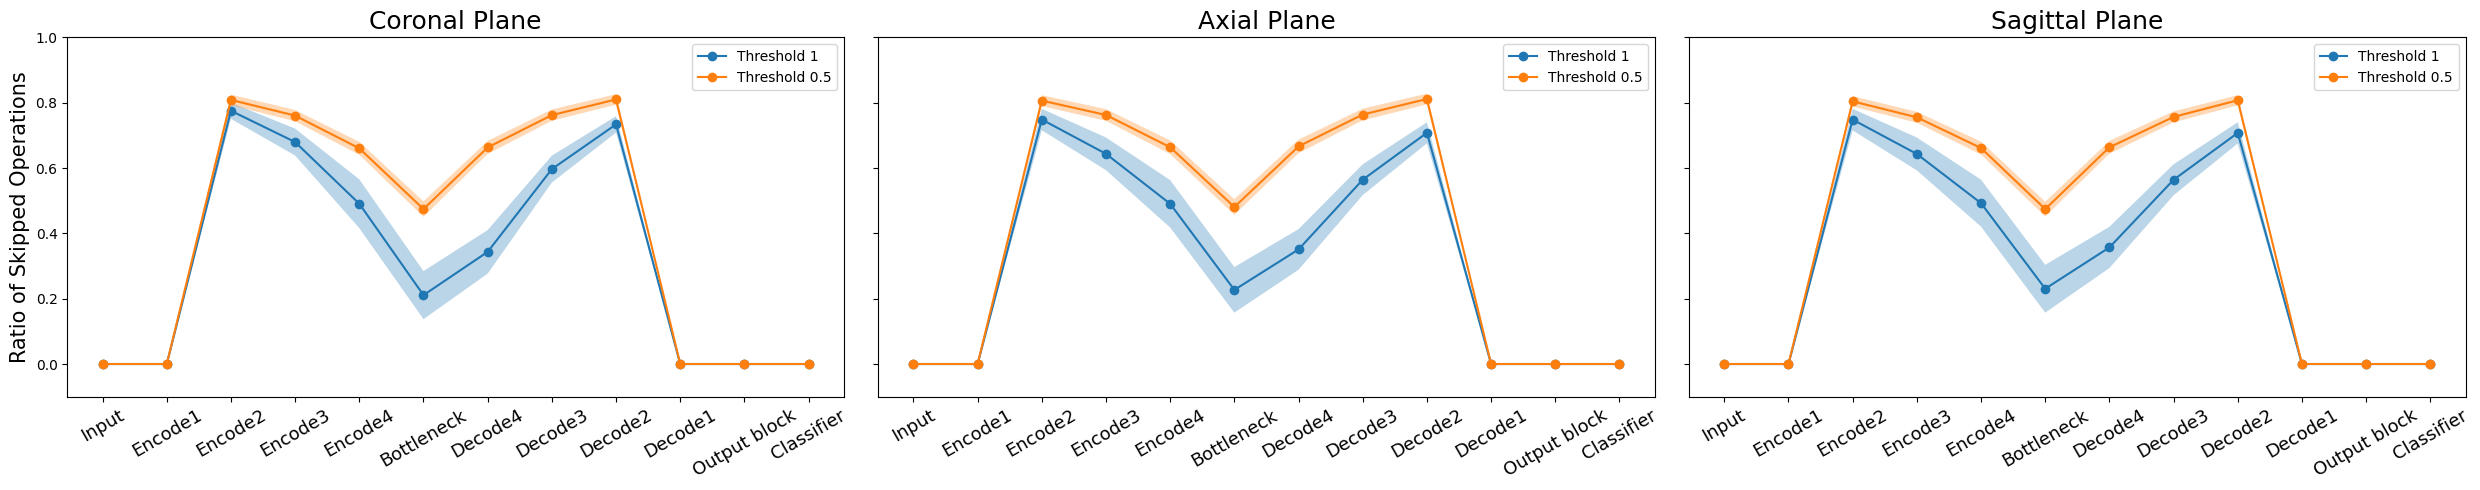

In [44]:
#nanratio per slice
fig, axes = plt.subplots(1, 3, figsize=(25,5), sharey=True)

nanratio_per_slice({'1': list(coronal_thresh1_5subs) + list(coronal_thresh1_10subs), 
                    '0.5': list(coronal_thresh05_5subs) + list(coronal_thresh05_10subs) }, trim=False, title='Coronal Plane', axes=axes[0])

nanratio_per_slice({'1': list(axial_thresh1_5subs) + list(axial_thresh1_10subs), 
                    '0.5': list(axial_thresh05_5subs) + list(axial_thresh05_10subs)}, trim=False, title='Axial Plane', axes=axes[1])

nanratio_per_slice({'1': list(sagittal_thresh1_5subs) + list(sagittal_thresh1_10subs), 
                    '0.5': list(sagittal_thresh05_5subs) + list(sagittal_thresh05_10subs)}, trim=False, title='Sagittal Plane', axes=axes[2])

axes[0].set_ylabel('Ratio of Skipped Operations', fontsize=15)
# plt.suptitle(f'Mean Skipped Count Operations Across Slices (Full Architecture)'), axes[2].legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.tight_layout()
plt.savefig('nanratio_per_slice_notrim.pdf', format="pdf", bbox_inches="tight")


#nanratio per architecture
fig, axes = plt.subplots(1, 3, figsize=(25,5), sharey=True)

average_block_ratio({'1': coronal_mean_ratios_thresh1, 
                     '0.5': coronal_mean_ratios_thresh05 }, 
                     title='Coronal Plane', axes=axes[0]) 

average_block_ratio({'1': axial_mean_ratios_thresh1, 
                     '0.5': axial_mean_ratios_thresh05 }, 
                     title='Axial Plane', axes=axes[1]) 

average_block_ratio({'1': sagittal_mean_ratios_thresh1, 
                     '0.5': sagittal_mean_ratios_thresh05 }, 
                     title='Sagittal Plane', axes=axes[2]) 

axes[0].set_ylabel('Ratio of Skipped Operations', fontsize=15)
# plt.suptitle(f'Mean Skipped Count Operations Across Model'), axes[2].legend(loc="upper left", bbox_to_anchor=(1, 1));
plt.tight_layout()
plt.savefig('nanratio_per_architecture.pdf', format="pdf", bbox_inches="tight")



**5 subjects**
![alt text](nanratio_per_architecture.png "NaN Ratio per Architecture")
![alt text](nanratio_per_slice_notrim.png "NaN Ratio per Slice No Trim")
![alt text](nanratio_per_slice_trim.png "NaN Ratio per Slice Trim")


## Make Dice max difference figures across subjects

### Dice loss figures

In [8]:

def calculate_loss(thresholds, subject_list, file_dir):
    os.chdir('/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/')

    # Load static resources only once
    from FastSurferCNN.data_loader.data_utils import get_labels_from_lut, unify_lateralized_labels, read_classes_from_lut, map_aparc_aseg2label
    from FastSurferCNN.models.losses import CombinedLoss

    sag_mask = ("Left-", "ctx-rh")
    combi = ["Left-", "Right-"]
    
    lut = read_classes_from_lut("/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/FastSurferCNN/config/FastSurfer_ColorLUT.tsv")
    labels, labels_sag = get_labels_from_lut(lut, sag_mask)
    lateralization = unify_lateralized_labels(lut, combi)
    
    fs_thresh = {}
    fs_ieee = {}

    # Preload classifiers in memory
    classifiers_cache = {}
    lock = threading.Lock()  # Thread lock for classifiers_cache

    def process_subject(sub):
        aseg_path = f'{file_dir}/{sub}/norm/mri/aparc.DKTatlas+aseg.deep_256.mgz' if sub == '0025531' else f'{file_dir}/{sub}/sub-{sub}/mri/aparc.DKTatlas+aseg.mgz'
        aseg_nocc_path = f'{file_dir}/{sub}/norm/mri/aseg.auto_noCCseg.mgz' if sub == '0025531' else f'{file_dir}/{sub}/sub-{sub}/mri/aseg.auto_noCCseg.mgz'

        # Efficient loading of .mgz files
        aseg = np.asarray(nib.load(aseg_path, mmap=True).get_fdata(), dtype=np.int16)
        aseg_nocc = np.asarray(nib.load(aseg_nocc_path, mmap=True).get_fdata(), dtype=np.int16)

        mapped_aseg, mapped_aseg_sag = map_aparc_aseg2label(
            aseg, labels, labels_sag, lateralization, aseg_nocc, processing='aparc'
        )

        loss = CombinedLoss()
        fs_thresh[sub] = {}
        fs_ieee[sub] = {'coronal': np.zeros((256, 3)), 'axial': np.zeros((256, 3)), 'sagittal': np.zeros((256, 3))}

        for thresh in thresholds:
            fs_thresh[sub][thresh] = {'coronal': np.zeros((256, 3)), 'axial': np.zeros((256, 3)), 'sagittal': np.zeros((256, 3))}
            # if thresh == '1': fs_ieee[sub]['ieee'] = {'coronal': np.zeros((256, 3)), 'axial': np.zeros((256, 3)), 'sagittal': np.zeros((256, 3))}

            for plane in ['coronal', 'axial', 'sagittal']:
                for i in range(256):
                    if i < 50 or i > 60: continue  # Skip indices not required for testing

                    # Preload classifiers if not cached
                    key_thresh = (sub, plane, thresh, i)
                    key_ieee = (sub, plane, i)
                    
                    with lock:
                        if key_thresh not in classifiers_cache:
                            try:
                                classifiers_cache[key_thresh] = pickle.load(open(f"{file_dir}/{sub}/{plane}/thresh{''.join(thresh.split('.'))}/1_classifier_{i}.pkl", 'rb'))
                            except FileNotFoundError:
                                classifiers_cache[key_thresh] = None
                        classifier_thresh1 = classifiers_cache[key_thresh]
                        
                        if thresh == '1' and key_ieee not in classifiers_cache:
                            try:
                                classifiers_cache[key_ieee] = pickle.load(open(f"{file_dir}/{sub}/ieee/{plane}/ieee_classifier_{i}.pkl", 'rb'))
                            except FileNotFoundError:
                                classifiers_cache[key_ieee] = None
                        classifier_ieee = classifiers_cache.get(key_ieee)

                    # Tensor operations
                    aseg_slice = {
                        'coronal': torch.tensor(mapped_aseg[:, :, i]).unsqueeze(0),
                        'axial': torch.tensor(mapped_aseg[:, i, :]).T.unsqueeze(0),
                        'sagittal': torch.tensor(mapped_aseg_sag[i].T).unsqueeze(0)
                    }[plane]

                    # Loss calculations (try batch operations if possible)
                    if classifier_thresh1 is not None:
                        fs_thresh[sub][thresh][plane][i, :] = list(loss(classifier_thresh1, aseg_slice, weight=1))
                    if thresh == '1' and classifier_ieee is not None:
                        fs_ieee[sub][plane][i, :] = list(loss(classifier_ieee, aseg_slice, weight=1))

        return fs_thresh[sub], fs_ieee[sub]

    # Multithreading with an increased number of workers
    with ThreadPoolExecutor(max_workers=50) as executor:
        results = executor.map(process_subject, subject_list)

    # Combine results
    for sub, (thresh_result, ieee_result) in zip(subject_list, results):
        fs_thresh[sub] = thresh_result
        fs_ieee[sub] = ieee_result

    return fs_thresh, fs_ieee

# Example usage


# fs_thresh, fs_ieee = calculate_loss(thresholds=['1', '0.5'], subject_list=['0025531', '0003002', '0025011', '0025248', '0025350'], file_dir='/scratch/ine5/fastsurfer_embeddings/results/cpptorch/')
fs_thresh, fs_ieee = calculate_loss(thresholds=['1'], subject_list=['0025531', '0003002' ], file_dir='/scratch/ine5/fastsurfer_embeddings/results/cpptorch/')

Initialized CrossEntropy2D with weight: None and reduction: none
Initialized CrossEntropy2D with weight: None and reduction: none


In [6]:
fs_thresh, fs_ieee = pickle.load(open('../fs_loss.pkl', 'rb'))

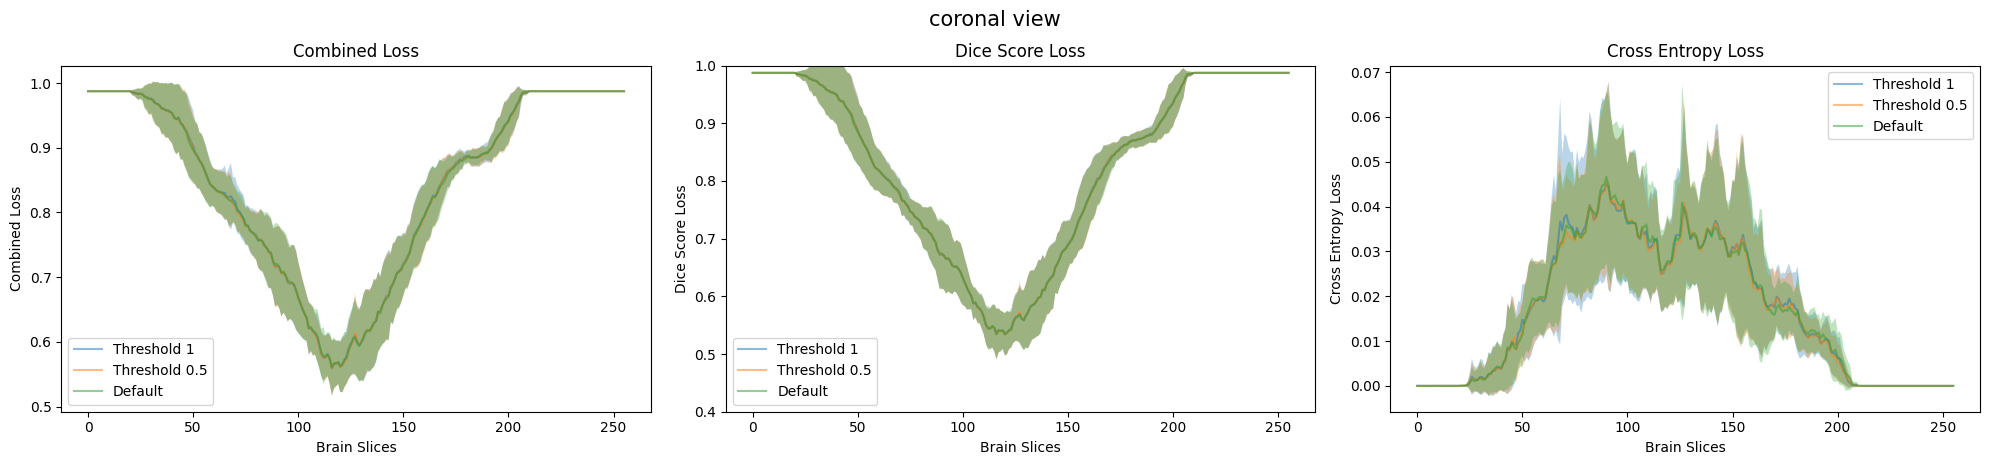

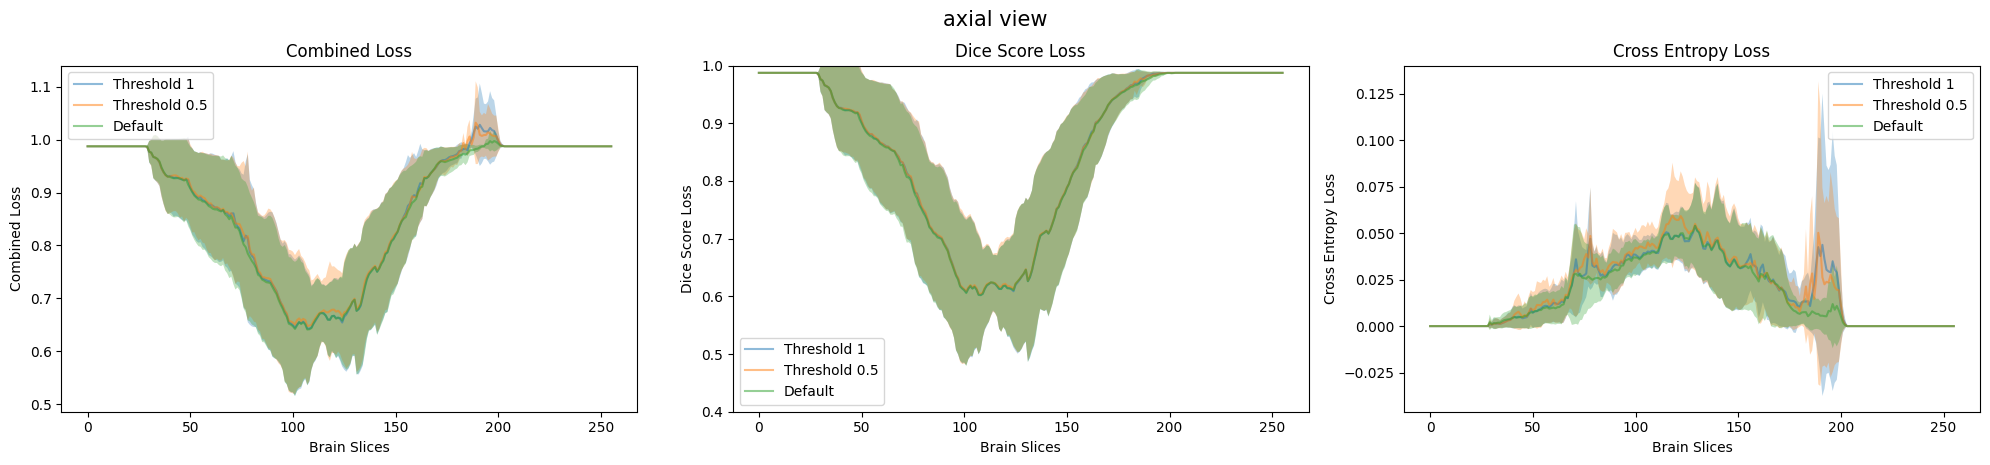

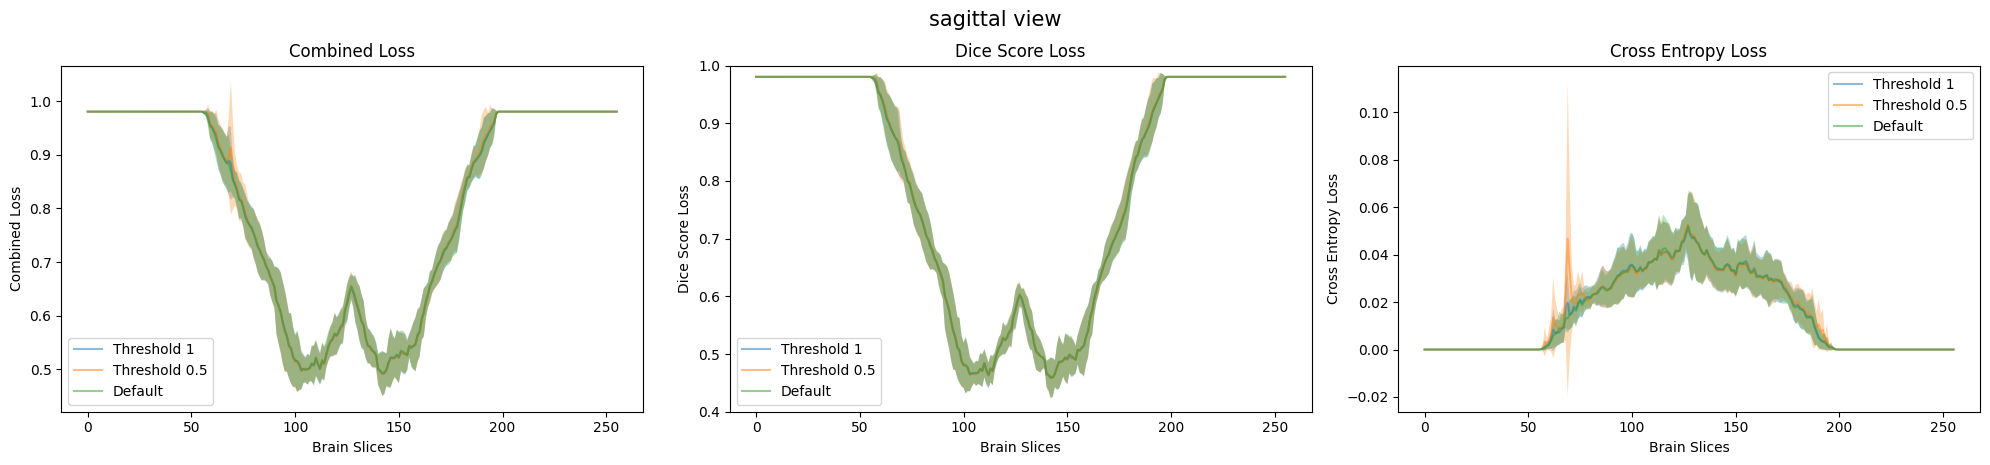

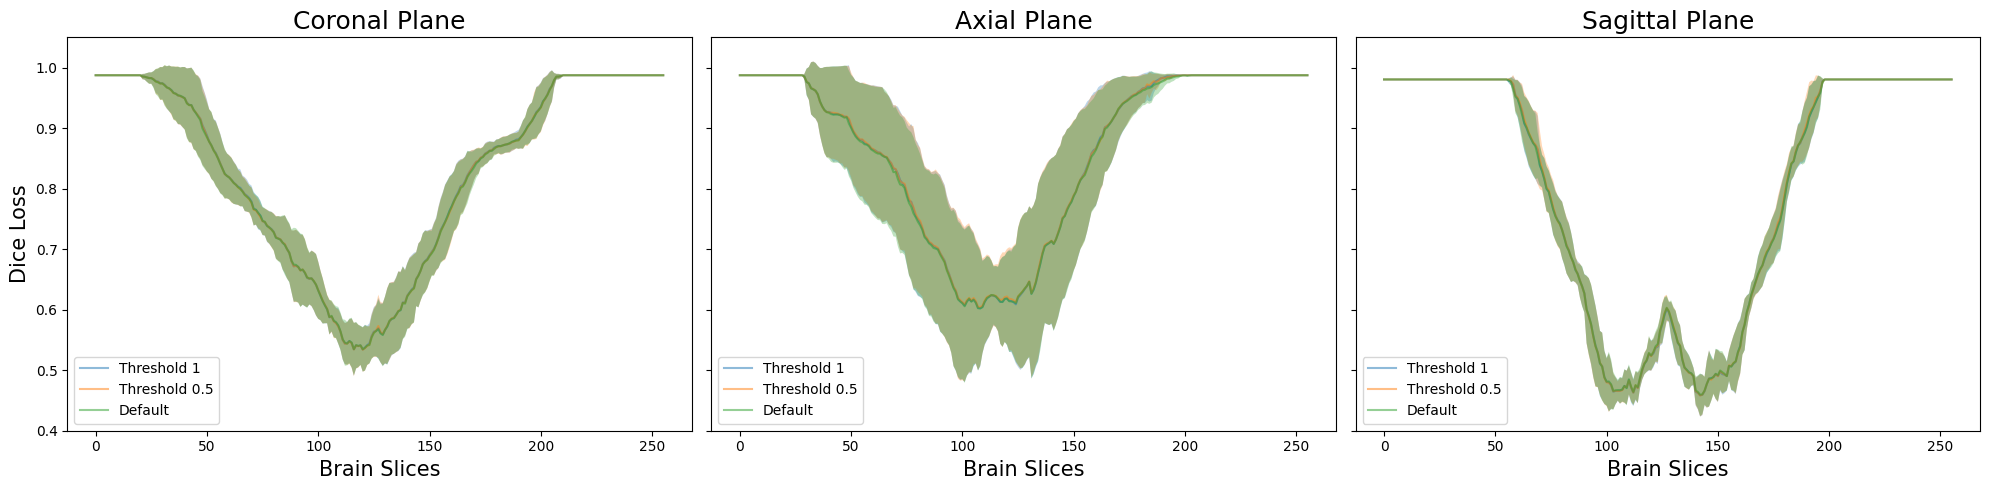

In [7]:
# Initialize a dictionary to store the averages
average_data_ieee = {}
average_data_thresh = {}

average_data_ieee = {}
for plane in ['coronal', 'axial', 'sagittal']:

    average_data_ieee[plane] = {'avg': [], 'std': []}

    # Collect data from all subjects for the current threshold and plane
    plane_data_ieee = [fs_ieee[sub][plane] for sub in ['0025531', '0003002', '0025011', '0025248', '0025350']]
    
    # Convert to a NumPy array for easier averaging
    plane_data_np_ieee = np.array(plane_data_ieee)
    
    # Calculate the average across subjects
    avg_values_ieee = np.mean(plane_data_np_ieee, axis=0)
    std_values_ieee = np.std(plane_data_np_ieee, axis=0)
    
    # Store the average in the result dictionary
    average_data_ieee[plane]['avg'] = avg_values_ieee.tolist()
    average_data_ieee[plane]['std'] = std_values_ieee.tolist()


for thresh in ['1', '0.5']:
    average_data_thresh[thresh] = {}
    for plane in ['coronal', 'axial', 'sagittal']:

        average_data_thresh[thresh][plane] = {'avg': [], 'std': []}

        # Collect data from all subjects for the current threshold and plane
        plane_data_thresh = [fs_thresh[sub][thresh][plane] for sub in ['0025531', '0003002', '0025011', '0025248', '0025350'] ]
        
        # Convert to a NumPy array for easier averaging
        plane_data_np_thresh = np.array(plane_data_thresh)
        
        # Calculate the average across subjects
        avg_values_thresh = np.mean(plane_data_np_thresh, axis=0)
        std_values_thresh = np.std(plane_data_np_thresh, axis=0)
        
        # Store the average in the result dictionary
        average_data_thresh[thresh][plane]['avg'] = avg_values_thresh.tolist()
        average_data_thresh[thresh][plane]['std'] = std_values_thresh.tolist()


# Assuming `average_data_ieee` and `average_data_thresh` are already defined and populated as dictionaries with average and std data

# Initialize a dictionary to store the averages
combo_ieee = {}
dice_ieee = {}
ce_ieee = {}

for plane, vals in average_data_ieee.items():
    combo_ieee[plane] = {'avg': np.array(vals['avg'])[:, 0], 'std': np.array(vals['std'])[:, 0]}
    dice_ieee[plane] = {'avg': np.array(vals['avg'])[:, 1], 'std': np.array(vals['std'])[:, 1]}
    ce_ieee[plane] = {'avg': np.array(vals['avg'])[:, 2], 'std': np.array(vals['std'])[:, 2]}

# Initialize dictionaries for threshold data
combo_thresh = {}
dice_thresh = {}
ce_thresh = {}

for thresh, planes_data in average_data_thresh.items():
    combo_thresh[thresh] = {plane: {'avg': np.array(vals['avg'])[:, 0], 'std': np.array(vals['std'])[:, 0]} for plane, vals in planes_data.items()}
    dice_thresh[thresh] = {plane: {'avg': np.array(vals['avg'])[:, 1], 'std': np.array(vals['std'])[:, 1]} for plane, vals in planes_data.items()}
    ce_thresh[thresh] = {plane: {'avg': np.array(vals['avg'])[:, 2], 'std': np.array(vals['std'])[:, 2]} for plane, vals in planes_data.items()}

# Plotting

for plane in ['coronal', 'axial', 'sagittal']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))


    for thresh in ['1', '0.5']:

        # Combined Loss
        axes[0].plot(combo_thresh[thresh][plane]['avg'], label=f'Threshold {thresh}', alpha=0.5)
        axes[0].fill_between(range(len(combo_thresh[thresh][plane]['avg'])), 
                            combo_thresh[thresh][plane]['avg'] - combo_thresh[thresh][plane]['std'], 
                            combo_thresh[thresh][plane]['avg'] + combo_thresh[thresh][plane]['std'], 
                            alpha=0.3)
        
        axes[0].set_title(f"Combined Loss")
        axes[0].set_xlabel('Brain Slices')
        axes[0].set_ylabel('Combined Loss')

        # Dice Score Loss
        axes[1].plot(dice_thresh[thresh][plane]['avg'], label=f'Threshold {thresh}', alpha=0.5)
        axes[1].fill_between(range(len(dice_thresh[thresh][plane]['avg'])), 
                            dice_thresh[thresh][plane]['avg'] - dice_thresh[thresh][plane]['std'], 
                            dice_thresh[thresh][plane]['avg'] + dice_thresh[thresh][plane]['std'], 
                            alpha=0.3)
        
        axes[1].set_title(f"Dice Score Loss")
        axes[1].set_xlabel('Brain Slices')
        axes[1].set_ylabel('Dice Score Loss')
        axes[1].set_ylim(0.4, 1)


        # Cross Entropy Loss
        axes[2].plot(ce_thresh[thresh][plane]['avg'], label=f'Threshold {thresh}', alpha=0.5)
        axes[2].fill_between(range(len(ce_thresh[thresh][plane]['avg'])), 
                            ce_thresh[thresh][plane]['avg'] - ce_thresh[thresh][plane]['std'], 
                            ce_thresh[thresh][plane]['avg'] + ce_thresh[thresh][plane]['std'], 
                            alpha=0.3)
                
        axes[2].set_title(f"Cross Entropy Loss")
        axes[2].set_xlabel('Brain Slices')
        axes[2].set_ylabel('Cross Entropy Loss')

    
    #Plot default
    axes[0].plot(combo_ieee[plane]['avg'], label='Default', alpha=0.5)
    axes[0].fill_between(range(len(combo_ieee[plane]['avg'])), 
                        combo_ieee[plane]['avg'] - combo_ieee[plane]['std'], 
                        combo_ieee[plane]['avg'] + combo_ieee[plane]['std'], 
                        alpha=0.3)
    axes[0].legend()

    axes[1].plot(dice_ieee[plane]['avg'], label='Default', alpha=0.5)
    axes[1].fill_between(range(len(dice_ieee[plane]['avg'])), 
                        dice_ieee[plane]['avg'] - dice_ieee[plane]['std'], 
                        dice_ieee[plane]['avg'] + dice_ieee[plane]['std'], 
                        alpha=0.3)
    axes[1].legend()

    axes[2].plot(ce_ieee[plane]['avg'], label='Default', alpha=0.5)
    axes[2].fill_between(range(len(ce_ieee[plane]['avg'])), 
                        ce_ieee[plane]['avg'] - ce_ieee[plane]['std'], 
                        ce_ieee[plane]['avg'] + ce_ieee[plane]['std'], 
                        alpha=0.3)
    axes[2].legend()
    # axes[2].set_title(f"Cross Entropy Loss\nDefault Mean: {np.mean(ce_ieee[plane]['avg']):.2f} NaN Mean: {np.mean(ce_thresh['avg']):.2f}"), axes[2].legend()

    fig.suptitle(f"{plane} view\n", fontsize=15, y=0.92)


    plt.tight_layout()
    plt.show()




# Plotting Just Dice Loss

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for num, plane in enumerate(['coronal', 'axial', 'sagittal']):
    for thresh in ['1', '0.5']:

        # Dice Score Loss
        axes[num].plot(dice_thresh[thresh][plane]['avg'], label=f'Threshold {thresh}', alpha=0.5)
        fill_between_poly = axes[num].fill_between(range(len(dice_thresh[thresh][plane]['avg'])), 
                            dice_thresh[thresh][plane]['avg'] - dice_thresh[thresh][plane]['std'], 
                            dice_thresh[thresh][plane]['avg'] + dice_thresh[thresh][plane]['std'], 
                            alpha=0.3)

        # Apply hatching to the filled region
        # for poly in fill_between_poly.get_paths():
        #     patch = plt.Polygon(poly.vertices, closed=True, fill=False, hatch='//', edgecolor='lightblue')
        #     axes[num].add_patch(patch)
        
        axes[num].set_title(f"{plane.title()} Plane", fontsize=18)
        axes[num].set_xlabel('Brain Slices', fontsize=15)
        axes[num].set_ylim(0.4, 1.05)


    #Plot default
    axes[num].plot(dice_ieee[plane]['avg'], label='Default', alpha=0.5)
    axes[num].fill_between(range(len(dice_ieee[plane]['avg'])), 
                        dice_ieee[plane]['avg'] - dice_ieee[plane]['std'], 
                        dice_ieee[plane]['avg'] + dice_ieee[plane]['std'], 
                        alpha=0.3)
    
    axes[num].legend()

axes[0].set_ylabel('Dice Loss', fontsize=15)

plt.tight_layout()
plt.savefig("dice_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Distribution of Dice differences across slices per subject 

Distribution of max dice differences across slices per subject 

max(FSnan - FS) across slices per subject 

Analysis: ensure that max positive -- means high values bad? check dice loss \

Do distribution plot (or box plot) of max differences for subjects (hopefully small) \

Do one sample t test to confirm mean is 0 (p > 0.05) on above plot


**Paired T test for Dice loss scores across NaN FastSurfer and Default FastSurfer**

In [36]:
t_stats = {'1': {}, '0.5': {}, 'ieee': {}}

for thresh in t_stats.keys():
    for plane in ['coronal', 'axial', 'sagittal']:
        t_stats[thresh][plane] = []

        for sub in ['0025531', '0003002', '0025011', '0025248', '0025350']:

            if thresh == 'ieee':
                data_ieee = fs_ieee[sub][plane][:,1]
                t_stats[thresh][plane].extend(data_ieee)                
            else: 
                data_thresh = fs_thresh[sub][thresh][plane][:,1]
                t_stats[thresh][plane].extend(data_thresh)

       

for thresh in ['1', '0.5']:
    for plane in ['coronal', 'axial', 'sagittal']:  
        _, p_value = stats.ttest_rel(t_stats['ieee'][plane], t_stats[thresh][plane])
        print(f"Threshold {thresh}, {plane}: {p_value:.3f}")

Threshold 1, coronal: 0.000
Threshold 1, axial: 0.000
Threshold 1, sagittal: 0.218
Threshold 0.5, coronal: 0.014
Threshold 0.5, axial: 0.000
Threshold 0.5, sagittal: 0.000


In [9]:
# Initialize dictionaries to store maximum differences
max_diff_per_subject = {}
mean_diff_per_subject = {}

# Loop through subjects
for sub in ['0025531', '0003002', '0025011', '0025248', '0025350']:
    max_diff_per_subject[sub] = {}
    mean_diff_per_subject[sub] = {}
    
    # Loop through thresholds
    for thresh in ['1', '0.5']:
        max_diff_per_subject[sub][thresh] = {}
        mean_diff_per_subject[sub][thresh] = {}

        # Loop through planes
        for plane in ['coronal', 'axial', 'sagittal']:

            # Extract Dice loss data for current subject, threshold, and plane
            data_thresh = fs_thresh[sub][thresh][plane][:,1]
            data_ieee = fs_ieee[sub][plane][:,1]
            
            # print(data_ieee[100] , data_thresh[100])
            # Calculate absolute differences
            # differences = np.abs(data_thresh - data_ieee)
            differences = data_ieee - data_thresh
            # print(differences)
            
            # Find the index of the maximum absolute difference
            max_abs_index = np.argmax(np.abs(differences))

            # Extract the largest absolute difference with its original sign
            max_diff = differences[max_abs_index]
            
            # Store the maximum difference
            max_diff_per_subject[sub][thresh][plane] = differences.flatten() #max_diff
            mean_diff_per_subject[sub][thresh][plane] = np.mean(differences)

# Print or further process `max_diff_per_subject` as needed
# print(max_diff_per_subject)

**Make Dice Loss Difference Plots**

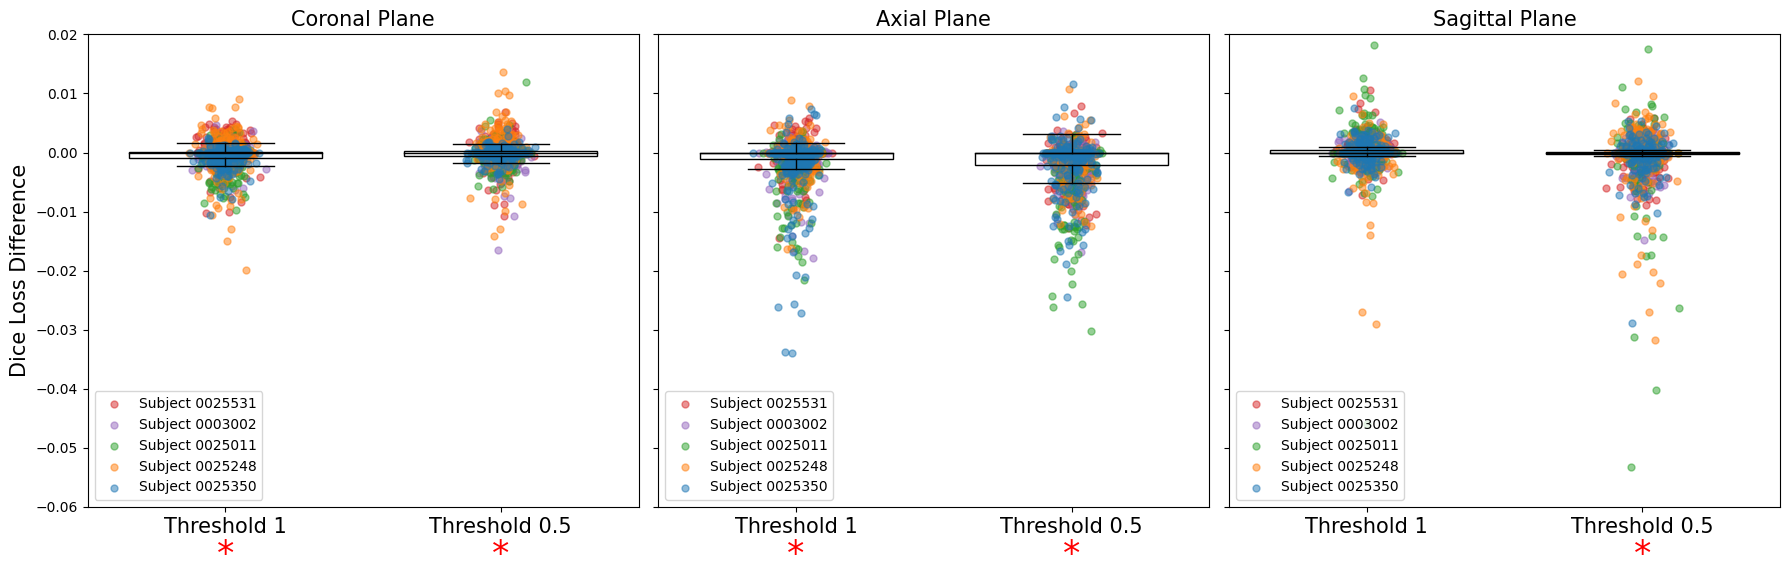

In [56]:
PROPS = {
    'boxprops': {'facecolor': 'none', 'edgecolor': 'black'},
    'medianprops': {'color': 'black'},
    'whiskerprops': {'color': 'black'},
    'capprops': {'color': 'black'}
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define significance stars
sig_stars = {'1': {'coronal': '*', 'axial': '*', 'sagittal': ''}, '0.5': {'coronal': '*', 'axial': '*', 'sagittal': '*'} }

# Define planes for subplots
planes = ['coronal', 'axial', 'sagittal']

# Define colors for subjects
# subject_colors = ['blue', 'green', 'orange', 'purple', 'red']
subject_colors = ['tab:red', 'tab:purple', 'tab:green', 'tab:orange', 'tab:blue']

sub_means = {'1': {'coronal':{}, 'axial': {}, 'sagittal':{}}, '0.5': {'coronal':{}, 'axial':{}, 'sagittal':{}} }

# Loop over planes
for idx, plane in enumerate(planes):
    # Initialize lists to collect data for plotting
    data_thresh_1 = []
    data_thresh_0_5 = []
    subjects = ['0025531', '0003002', '0025011', '0025248', '0025350']
    
    # Loop over subjects and thresholds to collect data
    for sub_index, sub in enumerate(subjects):
        data_thresh_1.append(max_diff_per_subject[sub]['1'][plane])
        data_thresh_0_5.append(max_diff_per_subject[sub]['0.5'][plane])
    
    data_thresh_1 = np.asarray(data_thresh_1)
    data_thresh_0_5 = np.asarray(data_thresh_0_5)
    
    # Boxplot of data for current plane
    bp = axes[idx].boxplot([data_thresh_1.flatten(), data_thresh_0_5.flatten()], labels=['Threshold: 1', 'Threshold: 0.5'],
                           patch_artist=True, widths=0.7, meanline=False, showmeans=False, showfliers=False, **PROPS)
    

    # _, p_value_thresh1 = stats.ttest_1samp(data_thresh_1.flatten(), 0)
    # _, p_value_thresh05 = stats.ttest_1samp(data_thresh_0_5.flatten(), 0)

    axes[idx].set_title(f"{plane.capitalize()} Plane", fontsize=15)
    axes[0].set_ylabel('Dice Loss Difference', fontsize=15)
    
    # Scatter plot of individual points with different colors for each subject
    for sub_index, sub in enumerate(subjects):
        # Generate x-values with jitter
        x_values_thresh1 = np.full_like(data_thresh_1[sub_index], 1) + np.random.normal(0, 0.04, size=len(data_thresh_1[sub_index]))
        x_values_thresh05 = np.full_like(data_thresh_0_5[sub_index], 2) + np.random.normal(0, 0.04, size=len(data_thresh_0_5[sub_index]))
        
        sub_means['1'][plane][sub] =  np.mean(data_thresh_1[sub_index])

        sub_means['0.5'][plane][sub] = np.mean(data_thresh_0_5[sub_index])

        # Scatter plot with subject-specific color
        axes[idx].scatter(x_values_thresh1, data_thresh_1[sub_index], alpha=0.5, color=subject_colors[sub_index], s=25)
        axes[idx].scatter(x_values_thresh05, data_thresh_0_5[sub_index], alpha=0.5, color=subject_colors[sub_index], label=f'Subject {sub}', s=25)
    
    axes[idx].set_xticks([1, 2])
    # if plane == 'sagittal':
    #     axes[idx].set_xticklabels(['Threshold 1', 'Threshold 0.5\n*'], fontsize=15)
    # else:

    axes[idx].set_xticklabels(['Threshold 1', 'Threshold 0.5'], fontsize=15)
        
    # Manually add large red asterisks below each x-tick label
    for i, label in enumerate(axes[idx].get_xticks()):
        if i == 0  and plane == 'sagittal': continue
        axes[idx].annotate('*', 
                    (label, 0),  # Positioning at the x-tick
                    xytext=(0, -297),  # Offset below the label
                    textcoords='offset points', 
                    color='red', 
                    fontsize=25, 
                    ha='center')  # Center align


        

    axes[idx].set_ylim(-0.06, 0.02)
    axes[idx].legend(loc='lower left')

# Adjust layout
plt.tight_layout()
plt.savefig("fsnan_fs_fulldistribution.pdf", format="pdf", bbox_inches="tight")

plt.show()


**Calculated Percentage of Difference of Most Extreme Outlier**

In [40]:
differences = fs_ieee['0025011']['sagittal'][:,1] - fs_thresh['0025011']['0.5']['sagittal'][:,1]

print('Extreme Outlier ', np.min(differences), ' Index: ', np.argmin(differences))

print('Dice loss values: ', fs_ieee['0025011']['sagittal'][69,1], fs_thresh['0025011']['0.5']['sagittal'][69,1])

print('Percentage of Differences: ', (np.min(differences)/fs_ieee['0025011']['sagittal'][69,1]*100), (np.min(differences)/fs_thresh['0025011']['0.5']['sagittal'][69,1])*100 )

Extreme Outlier  -0.05317425727844238  Index:  69
Dice loss values:  0.9272933006286621 0.9804675579071045
Percentage of Differences:  -5.734351498322342 -5.4233571370732125


**Calculated Percentage of Difference of Average Values -- No Outliers**

In [60]:
# Initialize dictionaries to store maximum differences
mean_vals = {}
diff_vals = {}

# Loop through thresholds and subjects to populate mean_vals and diff_vals
for thresh in ['1', '0.5']:
    mean_vals[thresh] = []
    diff_vals[thresh] = []
    for sub in ['0025531', '0003002', '0025011', '0025248', '0025350']:
        for plane in ['coronal', 'axial', 'sagittal']:
            # Extract Dice loss data for current subject, threshold, and plane
            data_thresh = fs_thresh[sub][thresh][plane][:,1]
            data_ieee = fs_ieee[sub][plane][:,1]
            
            # Calculate differences and flatten the arrays
            differences = data_ieee - data_thresh
            diff_vals[thresh].append(differences.flatten())
            mean_vals[thresh].append(data_ieee.flatten())

    # Flatten and convert lists to arrays for threshold 
    data_thresh = np.concatenate(diff_vals[thresh])
    mean_thresh = np.concatenate(mean_vals[thresh])

    # Compute the mean and standard deviation for data_thresh
    mean_diff = np.mean(data_thresh)
    std_diff = np.std(data_thresh)

    # Define the threshold for outliers (e.g., within 2 standard deviations)
    threshold = 2

    # Filter values that are within 'threshold' standard deviations
    filtered_indices = np.where(np.abs(data_thresh - mean_diff) <= threshold * std_diff)[0]

    # Get corresponding mean values for these filtered indices
    filtered_means = mean_thresh[filtered_indices]
    filtered_diffs = data_thresh[filtered_indices]

    # Calculate the mean of the filtered data
    mean_filtered_data = np.mean(filtered_means)

    # Output
    # print(f"Threshold {thresh} Filtered indices: {filtered_indices}")
    print(f"Threshold {thresh} Mean of filtered data: {mean_filtered_data}")
    print(f"Threshold {thresh} Mean of differences between NaN and IEEE {np.mean(filtered_diffs):.4f}")
    print(f"Threshold {thresh} Percentage of Change (No Outliers): {(np.mean(filtered_diffs)/mean_filtered_data)*100}%")
    print(f"Threshold {thresh} Percentage of Change (No Outliers): {(mean_diff/np.mean(mean_thresh))*100}%")


Threshold 1 Mean of filtered data: 0.8310165131189121
Threshold 1 Mean of differences between NaN and IEEE -0.0002
Threshold 1 Percentage of Change (No Outliers): -0.02030546611334521%
Threshold 1 Percentage of Change (No Outliers): -0.05690289160900897%
Threshold 0.5 Mean of filtered data: 0.832748951582233
Threshold 0.5 Mean of differences between NaN and IEEE -0.0003
Threshold 0.5 Percentage of Change (No Outliers): -0.03936032939519254%
Threshold 0.5 Percentage of Change (No Outliers): -0.08782169500650801%


**Rank Subjects In terms of Best to Worst Differences**

In [67]:
def rank_subjects(data):
    ranked_subjects = {}
    
    # Iterate over each threshold
    for threshold, planes_data in data.items():
        # Initialize a dictionary to store combined values for each subject
        combined_values = {}
        
        # Iterate over each plane (coronal, axial, sagittal)
        for plane, subjects_data in planes_data.items():
            # Iterate over each subject in the plane
            for subject, value in subjects_data.items():
                # If subject not in combined_values, initialize with an empty list
                if subject not in combined_values:
                    combined_values[subject] = []
                
                # Append the value for the current plane and threshold
                combined_values[subject].append(value)
        
        # Now calculate combined score and sort subjects by it
        sorted_subjects = sorted(combined_values.items(), key=lambda x: sum(x[1]), reverse=True)
        
        # Extract subjects sorted by combined score
        ranked_subjects[threshold] = [subject for subject, _ in sorted_subjects]
    
    return ranked_subjects


ranked_subjects = rank_subjects(sub_means)

# Print the ranked subjects for each threshold
for threshold, subjects in ranked_subjects.items():
    print(f"For threshold {threshold}:")
    for rank, subject in enumerate(subjects, start=1):
        print(f"{rank}. {subject}")
    print()


For threshold 1:
1. 0025531
2. 0025248
3. 0003002
4. 0025350
5. 0025011

For threshold 0.5:
1. 0025248
2. 0025531
3. 0025350
4. 0003002
5. 0025011



## Difference Maps

Make difference maps of segmentations between nan and default where white (or some color not used by segs) marks disagreement -- do it for extreme subjects on distribution (mean very good subjects; close to FreeSurfer but maybe far to FastSurfer or bad subjects far from FastSurfer and FreeSurfer)


In [3]:
aseg_thresh1 = nib.load('../../results/cpptorch/0003002/norm.mgz/mri/aseg.auto_noCCseg_thresh1.mgz')
aseg_thresh05 = nib.load('../../results/cpptorch/0003002/norm.mgz/mri/aseg.auto_noCCseg_thresh05.mgz')
aseg_ieee = nib.load('../../results/cpptorch/0003002/ieee/norm.mgz/mri/aseg.auto_noCCseg.mgz')

In [70]:
def diff_images(img1_path, img2_path):
    # Load images
    img1 = nib.load(img1_path)
    img2 = nib.load(img2_path)
    
    # Get data arrays
    data1 = img1.get_fdata()
    data2 = img2.get_fdata()
    
    # Compute differences
    differences = data1 - data2
    
    # Create a mask to identify non-matching voxels
    mask = (data1 != data2)
    
    # Apply mask to set non-matching voxels to NaN
    #125 == 173,255,47,0 = neon green
    #150 == bright red
    differences[mask] = 150
    
    # Create a new NIfTI image with NaNs where differences occurred
    diff_img = nib.Nifti1Image(differences, img1.affine, img1.header)
    
    return diff_img


for thresh in ['1', '05']:
    for sub in ['0025531', '0003002', '0025011', '0025248', '0025350']:
        diff_img = diff_images( f'../../results/cpptorch/{sub}/ieee/norm.mgz/mri/aseg.auto_noCCseg.mgz', f'../../results/cpptorch/{sub}/norm.mgz/mri/aseg.auto_noCCseg_thresh{thresh}.mgz')
        nib.save(diff_img, f'/scratch/ine5/fastsurfer_embeddings/fastsurfer-embeddings/embedding_project/{sub}_diffseg_thresh{thresh}.mgz')
